## 1. Configurations

### 1.1. Importing Libs

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import warnings
import seaborn as sns
import pycountry
import requests
import plotly.express as px
import nbformat

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap



warnings.filterwarnings('ignore')
%matplotlib inline

### 1.2. Definindo os caminhos

In [3]:
dir_atual = os.path.dirname(os.path.abspath('__file__'))
root_dir = os.path.abspath(os.path.join(dir_atual, '..'))
input_path = os.path.join(dir_atual, 'input')
formas_paises_url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'

### 1.3. Lendo o arquivo

In [4]:
df = pd.read_csv(os.path.join(input_path, 'netflix_titles.csv'))


output_path = os.path.join(input_path, 'global_polygons.geojson')
response = requests.get(formas_paises_url)
if response.status_code == 200:
    with open(output_path, 'wb') as file:
        file.write(response.content)
else:
    raise 'Erro ao fazer o download do arquivo'

global_poligonos = gpd.read_file(output_path)
global_poligonos.to_file('global_polygons.geojson', driver='GeoJSON')


In [4]:
global_poligonos

,id,name,geometry
0,AFG,Afghanistan,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,"POLYGON ((20.59025 41.8554, 20.46318 41.51509,..."
3,ARE,United Arab Emirates,"POLYGON ((51.57952 24.2455, 51.75744 24.29407,..."
4,ARG,Argentina,"MULTIPOLYGON (((-65.5 -55.2, -66.45 -55.25, -6..."
...,...,...,...
172,PSE,West Bank,"POLYGON ((35.54566 32.39399, 35.54525 31.7825,..."
173,YEM,Yemen,"POLYGON ((53.10857 16.65105, 52.38521 16.38241..."
174,ZAF,South Africa,"POLYGON ((31.521 -29.25739, 31.32556 -29.40198..."
175,ZMB,Zambia,"POLYGON ((32.75938 -9.2306, 33.23139 -9.67672,..."


### 1.3. Limpando o arquivo
Vamos limpar os dados onde há valores nulos

In [5]:
df['country'] = df['country'].fillna('No Data')
df['cast'].replace(np.nan, 'No Data',inplace  = True)
df['director'].replace(np.nan, 'No Data',inplace  = True)

df.dropna(inplace=True)
df.drop_duplicates(inplace= True)

df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

### 1.4. Ajustando a data

In [6]:
df['date_added'] = df['date_added'].str.strip()
df['date_added'] = pd.to_datetime(df['date_added'])
df['month_added']=df['date_added'].dt.month
df['month_name_added']=df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,month_name_added,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,September,2021
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,September,2021
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Data,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,September,2021


### 1.5. Cores

As cores foram obtidas do próprio [Brand Assets](https://brand.netflix.com/en/assets/logos) da Netflix em:

In [7]:
net_dark = '#101010'
net_red = '#B92028'
net_dark_red = '#B20710'
net_light = '#F5F5F1'

### 1.6. Auxiliares

In [8]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

country_mapping = {
    "South Korea": "Korea, Republic of",
    "Russia": "Russian Federation",
    "Taiwan": "Taiwan, Province of China",
    "Czech Republic": "Czechia",
    "Soviet Union": "USSR",  # Não existe código atual
    "West Germany": "Germany",  # Não existe código atual
    "Venezuela": "Venezuela, Bolivarian Republic of",
    "Turkey": "Türkiye",
    "Vietnam": "Viet Nam",
    "Syria": "Syrian Arab Republic",
    "Iran": "Iran, Islamic Republic of"
}

def alpha3code(column):
    CODE = []
    for country in column:
        if country in country_mapping:
            mapped_country = country_mapping[country]
        else:
            mapped_country = country
        
        if mapped_country:
            try:
                # Tentar obter o código alpha-3
                code = pycountry.countries.get(name=mapped_country).alpha_3
                CODE.append(code)
            except AttributeError:
                # Caso não encontre o país, retorna 'None'
                CODE.append('None')
        else:
            # Caso o mapeamento retorne None (ex: Soviet Union), adiciona 'None'
            CODE.append('None')
    
    return CODE

## 2. Distribuição por conteúdo

Text(0.215, 0.2, 'Séries')

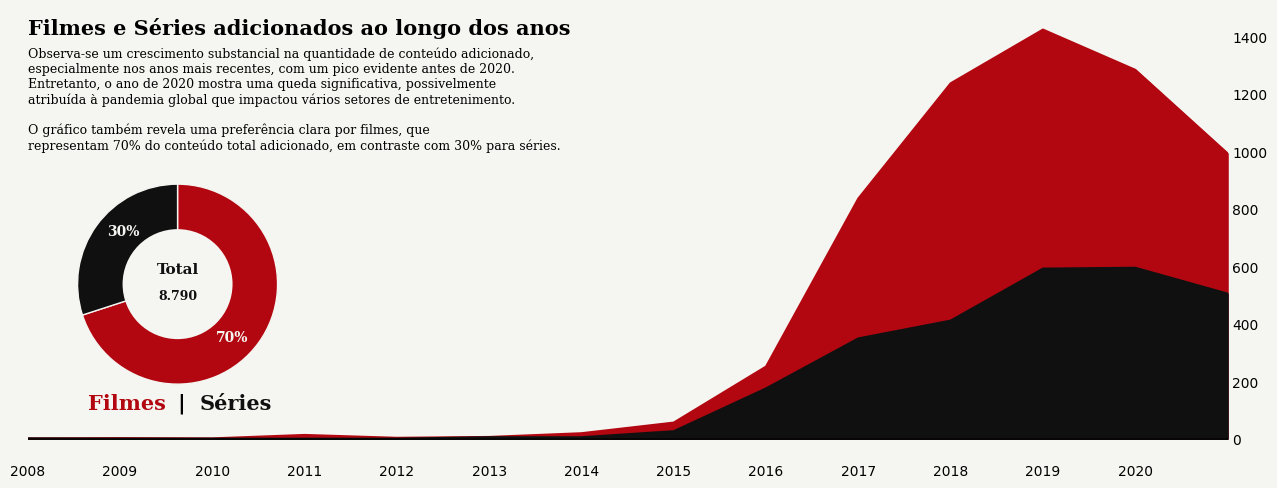

In [9]:
content_group = df.groupby(['type'])['type'].count()

total = int(content_group.sum())    # Total of ocorrences
ratio = (content_group/total).round(2)  # Ratio of each ocorrence
perc = pd.DataFrame(ratio).T    # Transforme in a DataFrame and Transpose

labels = ['Movies', 'TV Shows']
sizes = [perc['Movie'][0], perc['TV Show'][0]]
colors = [net_dark_red, net_dark]


fig = plt.figure(figsize=(15, 5), facecolor=net_light)

ax = [None for _ in range(6)]

ax[0] = fig.add_axes([0.1,0.1,0.8,0.9], facecolor=net_light) # x, y, dx, dy
ax[1] = fig.add_axes([0.05,0.20,0.3,0.5], facecolor=net_light)

wedges, texts = ax[1].pie(
    sizes, labels=labels, colors=colors, startangle=90, counterclock=False,
    autopct=None, pctdistance=0.85, wedgeprops={'edgecolor': net_light}
    )

# Criando o "buraco" no meio para formar o donut
centre_circle = plt.Circle((0, 0), 0.55, fc=net_light)
fig.gca().add_artist(centre_circle)

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Calcula o ângulo médio do setor
    x = 0.67 * np.cos(np.radians(angle))  # Converter para coordenada x
    y = 0.9 * np.sin(np.radians(angle))  # Converter para coordenada y

    ax[1].annotate(
        f'{int(sizes[i] * 100)}%',
        xy=(x, y),
        ha='center', va='center', 
        fontsize=10, fontfamily='serif', fontweight='bold', color=net_light
    )

# Removendo o título dos wedges
for text in texts:
    text.set_text('')


ax[1].annotate(
    text='Total',
    xy=(0,0.15),
    ha='center', va='center', 
    fontsize=11, fontfamily='serif', fontweight='bold', color=net_dark
)

ax[1].annotate(
    text=f'{total:,.0f}'.replace(",","."),
    xy=(0,-.11),
    ha='center', va='center', 
    fontsize=9, fontfamily='serif', fontweight='bold', color=net_dark
)

# -------------------------------------------------------------------------
# Distribuição temporal

content_group_temp = df.groupby(['year_added', 'type'])['year_added'].count().unstack().reset_index().fillna(0)

ax[0].plot(content_group_temp['year_added'], content_group_temp['Movie'], color=net_dark_red)
ax[0].plot(content_group_temp['year_added'], content_group_temp['TV Show'], color=net_dark)

ax[0].fill_between(content_group_temp['year_added'], 0,content_group_temp['Movie'], color=net_dark_red, alpha=1)
ax[0].fill_between(content_group_temp['year_added'], 0,content_group_temp['TV Show'], color=net_dark, alpha=1)

ax[0].grid(False)
ax[0].set_xlim(2008,2021)
ax[0].set_xticks(np.arange(2008, 2021, 1))
ax[0].yaxis.tick_right()
ax[0].tick_params(axis='both', which='both',length=0)
ax[0].axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

for s in ['top', 'right','bottom','left']:
    ax[0].spines[s].set_visible(False)

fig.text(0.1,0.95, s='Filmes e Séries adicionados ao longo dos anos', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(
    0.1,0.69, 
    s='''
Observa-se um crescimento substancial na quantidade de conteúdo adicionado,
especialmente nos anos mais recentes, com um pico evidente antes de 2020.
Entretanto, o ano de 2020 mostra uma queda significativa, possivelmente
atribuída à pandemia global que impactou vários setores de entretenimento.

O gráfico também revela uma preferência clara por filmes, que 
representam 70% do conteúdo total adicionado, em contraste com 30% para séries.
    ''',
      fontsize=9, fontweight='light', fontfamily='serif')

fig.text(0.14,0.2, s='Filmes', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark_red)
fig.text(0.2,0.2, s='|', fontsize=15, fontweight='bold', fontfamily='serif', color='black')
fig.text(0.215,0.2, s='Séries', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark)


## 3. Distribuição Mês a Mês

Text(0.82, 0.83, 'Séries')

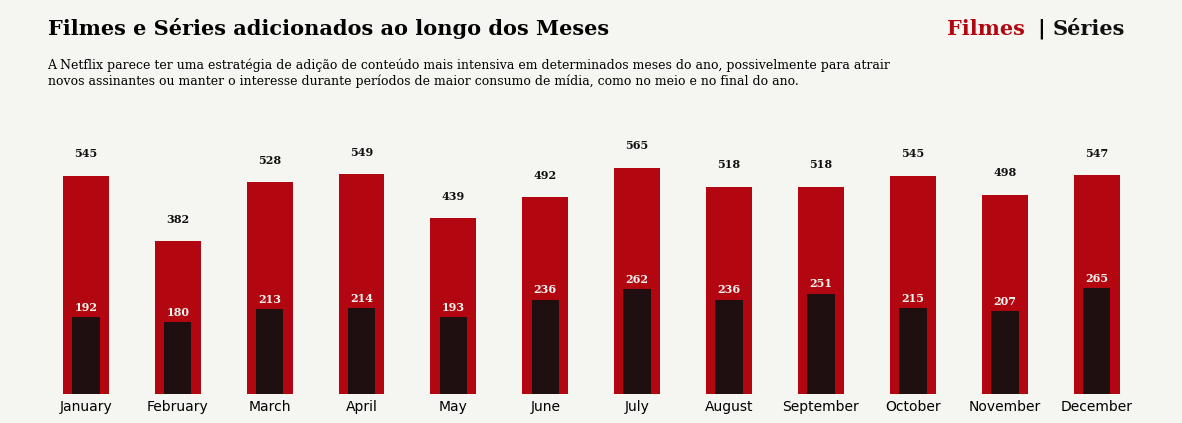

In [10]:
content_group_mes = df.groupby(['month_name_added', 'type'])['month_name_added'].count().unstack().reset_index().fillna(0)

# Ordenando de acordo com o calendário
ordem_meses = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

content_group_mes['month_name_added'] = pd.Categorical(
    content_group_mes['month_name_added'], 
    categories=ordem_meses, 
    ordered=True
)

content_group_mes = content_group_mes.sort_values('month_name_added').reset_index(drop=True)

content_group_mes['Total'] = content_group_mes['Movie'] + content_group_mes['TV Show']

v_max_filme = int(content_group_mes['Movie'].max())
v_max_serie = int(content_group_mes['TV Show'].max())

color_map_filme = ['#B8B8B8' if count != v_max_filme else net_dark_red for count in content_group_mes['Movie']]
color_map_serie = ['#777777' if count != v_max_serie else net_dark for count in content_group_mes['TV Show']]

fig, ax = plt.subplots(1,1, figsize=(15,5), facecolor=net_light)
ax.set_facecolor(net_light)

ax.bar(content_group_mes['month_name_added'], content_group_mes['Movie'], color=net_dark_red, width=0.5)
ax.bar(content_group_mes['month_name_added'], content_group_mes['TV Show'], color=net_dark, width=0.3, alpha=0.9)

ax.grid(False)

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)

ax.set_ylim(0, max(v_max_filme, v_max_serie) * 1.7)

for i in content_group_mes.index:
    ax.annotate(f"{content_group_mes.at[i, 'Movie']}", 
                xy=(i, content_group_mes.at[i, 'Movie'] +  v_max_filme*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8, color=net_dark)
    
    ax.annotate(f"{content_group_mes.at[i, 'TV Show']}", 
                xy=(i, content_group_mes.at[i, 'TV Show'] +  v_max_serie*0.1),
                va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8, color=net_light)

fig.text(0.15,0.83, s='Filmes e Séries adicionados ao longo dos Meses', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(
    0.15, 0.7, 
    s='''
A Netflix parece ter uma estratégia de adição de conteúdo mais intensiva em determinados meses do ano, possivelmente para atrair
novos assinantes ou manter o interesse durante períodos de maior consumo de mídia, como no meio e no final do ano.
    ''',
    fontsize=9, fontweight='light', fontfamily='serif'
)

fig.text(0.75,0.83, s='Filmes', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark_red)
fig.text(0.81,0.83, s='|', fontsize=15, fontweight='bold', fontfamily='serif', color='black')
fig.text(0.82,0.83, s='Séries', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark)


## Países

Vamos analisar os países produtores de conteúdo.
A coluna de Páis, em alguns casos, possui mais de um país registrado, vamos considerar apenas o primeiro país para essa analise

### Criando coluna do Primeiro País

In [38]:
paises = df[df['country'] != 'No Data']

paises['primeiro_pais'] = paises['country'].apply(lambda x: x.split(",")[0])

paises['cod_pais'] = alpha3code(paises['primeiro_pais'])

### Distribuição de conteúdo por país
Aqui iremos capturar o 10 maiores países em questão de produção de conteúdo adcionados ao catálago da Netflix

Text(0.87, 0.6, '\nPor se tratadar de uma empresa norte americana (a casa da Netflix),\né de se esperar que os Estados Unidos \nestejam em primeiro lugar na pordução de séries e filmes.\n')

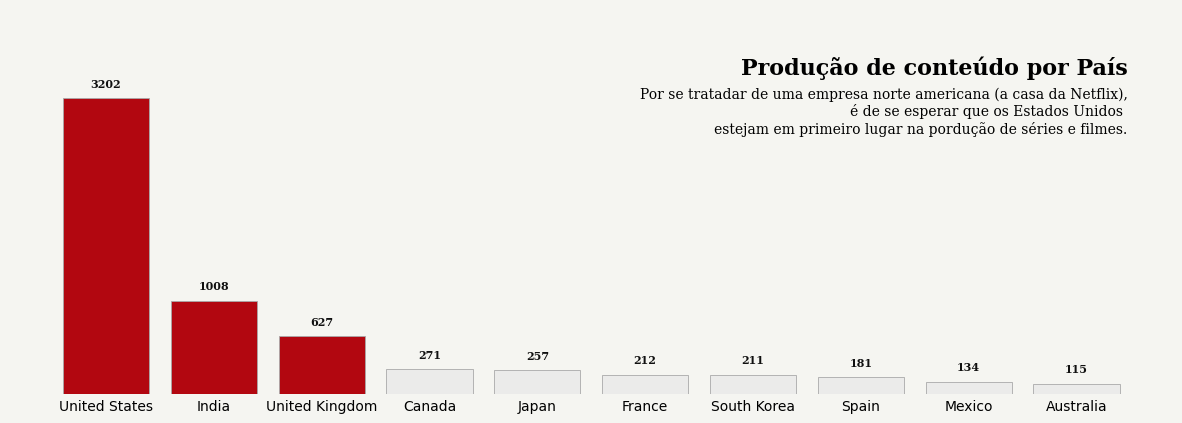

In [40]:
top_10_paises = paises.groupby(['primeiro_pais'])['primeiro_pais'].count().sort_values(ascending=False)[:10]

color_map = ['#EBEBEA' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] = net_dark_red

fig, ax = plt.subplots(1,1, figsize=(15,5), facecolor=net_light)
ax.set_facecolor(net_light)

ax.bar(x=top_10_paises.index, height=top_10_paises.values, color=color_map, edgecolor='darkgray',linewidth=0.6)

ax.grid(False)

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.set_yticklabels([])
ax.tick_params(axis='both', which='both',length=0)

ax.set_ylim(0,  int(top_10_paises.values[0])* 1.3)

for i, pais in enumerate(top_10_paises.index):
    ax.annotate(
        text=f'{int(top_10_paises.values[i])}',
        xy=(i, top_10_paises.values[i] + int(top_10_paises.values[0])* 0.05),
        va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8, color=net_dark
    )


fig.text(0.87,0.75, s='Produção de conteúdo por País', fontsize=16, fontweight='bold', fontfamily='serif', ha='right')
fig.text(
    0.87,0.60,
    s='''
Por se tratadar de uma empresa norte americana (a casa da Netflix),
é de se esperar que os Estados Unidos 
estejam em primeiro lugar na pordução de séries e filmes.
''',
    fontsize=10, fontweight='light', fontfamily='serif', ha='right')


### Tipo de de conteúdo por país

Text(0.88, 0.15, 'Relação entre País e Conteúdo [Top 10]')

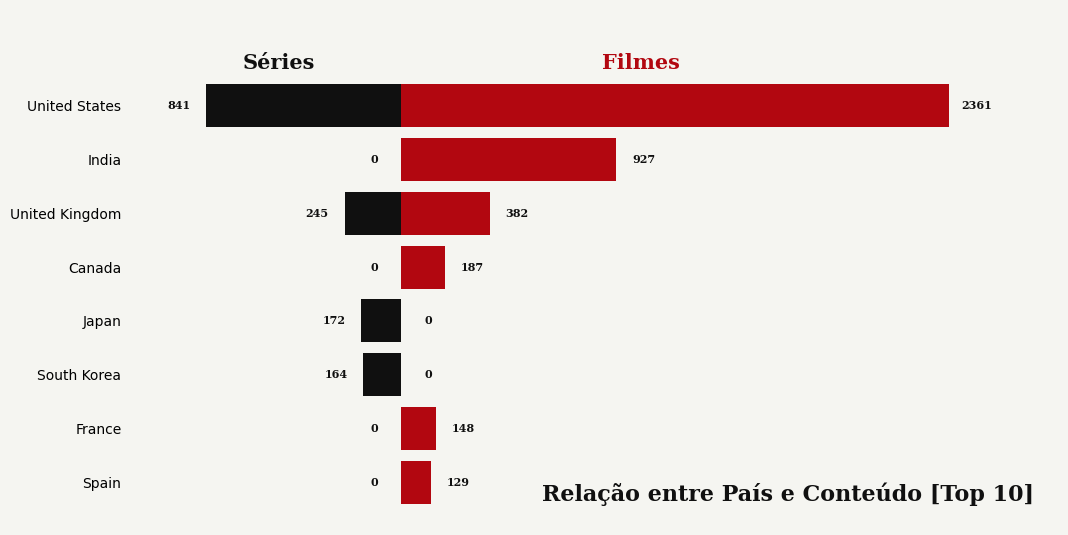

In [128]:
top_10_paises = paises.groupby(['primeiro_pais', 'type'])['primeiro_pais'].count().sort_values(ascending=False)[:10]
top_10_paises = top_10_paises.unstack().reset_index().fillna(0)

top_10_paises['total'] = top_10_paises['Movie'] + top_10_paises['TV Show'].fillna(0)
top_10_paises = top_10_paises.sort_values(by='total', ascending=True).reset_index(drop=True)

x_min = int(top_10_paises['TV Show'].max())
x_max = int(top_10_paises['Movie'].max())

fig, ax = plt.subplots(1,1, figsize=(12,6), facecolor=net_light)
ax.set_facecolor(net_light)
y_pos = np.arange(len(top_10_paises['primeiro_pais']))
ax.barh(y_pos, top_10_paises['Movie'], align='center', color=net_dark_red, label='Movies')
ax.barh(y_pos, -top_10_paises['TV Show'], align='center', color=net_dark, label='TV Shows')

ax.set_yticks(y_pos)
ax.set_yticklabels(top_10_paises['primeiro_pais'])
ax.set_xlim(-(x_min*1.4), x_max*1.2)

ax.grid(False)

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.tick_params(axis='both', which='both',length=0)
ax.set_xticklabels([])
ax.tick_params(axis='y', pad=5) 
ax.tick_params(axis='x', pad=5) 

for i, pais in enumerate(top_10_paises['primeiro_pais']):
    ax.annotate(
        text=f'{int(top_10_paises['Movie'][i])}',
        xy=(int(top_10_paises['Movie'][i])+x_max*0.05, i),
        va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8, color=net_dark
    )

    ax.annotate(
        text=f'{int(top_10_paises['TV Show'][i])}',
        xy=((-int(top_10_paises['TV Show'][i])-x_max*0.05, i)),
        va='center', ha='center', fontweight='bold', fontfamily='serif', fontsize=8, color=net_dark
    )


fig.text(0.22,0.87,s='Séries', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark)
fig.text(0.52,0.87,s='Filmes', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark_red)
fig.text(0.5,.95,s=' ')
fig.text(0.88, 0.15, 'Relação entre País e Conteúdo [Top 10]',
        ha='right',
         fontsize=16, fontweight='bold', fontfamily='serif', color=net_dark
    )
